In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


# Импорт библиотек

In [ ]:
!pip install contractions -q
!pip install emoji -q
!pip install -U sentence-transformers -q
!pip install xgboost==1.6.1 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.9/457.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.9/192.9 MB 6.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import contractions
import emoji
import string
from sentence_transformers import SentenceTransformer, CrossEncoder
import xgboost
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import pickle
import torch
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Импорт данных

Датасет про происшествия:
https://www.kaggle.com/competitions/nlp-getting-started/data

In [ ]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c nlp-getting-started
!unzip nlp-getting-started.zip

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 131MB/s]
Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
train = pd.read_csv('/content/train.csv', usecols=[3, 4])

In [ ]:
train

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


<Axes: ylabel='Count'>

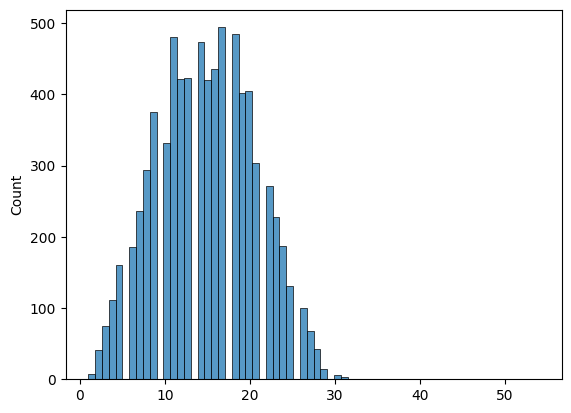

In [ ]:
sns.histplot([len(text.split(' ')) for text in train.text])

# Препроцессинг данных

Сделаем препроцессинг:

In [ ]:
def preprocessing(text, stopwords):

  text = ' '.join([contractions.fix(word) for word in text.split()])
  text = ' ' + text + ' '
  text = ' '.join([word for word in text.split() if emoji.is_emoji(word) == False])
  text = ' ' + text + ' '
  text = re.sub(r"[{}]".format(string.punctuation) + '|\n|\t', '', text)
  while re.findall(r'\shttp\S*\s|\swww\S*\s', text):
    text = re.sub(r'\shttp\S*\s|\swww\S*\s', ' ', text)
  while re.findall(r'\sRe\s|\sre\s', text):
    text = re.sub(r'\sRe\s|\sre\s', ' ', text)
  text = re.sub('\d', '', text)
  text = re.sub('\s+', ' ', text)
  text = text.lower()
  text = text.strip()
  text = ' '.join([word for word in text.split() if word not in stopwords])

  return text

In [ ]:
en_stopwords = stopwords.words("english")
additional_stop_words = ['\\a', '\x89û', 'å', 'å£', 'å¤', 'å¨', 'åç', 'åè', 'åê', 'ì¢', 'ìñ', 'ìü']
for word in additional_stop_words:
  en_stopwords.append(word)

In [ ]:
text_prep = train.text.apply(lambda text: preprocessing(text, en_stopwords))
text_prep = text_prep.drop_duplicates()
labels = pd.Series([train.target.loc[index] for index in text_prep.index], index=text_prep.index)

In [ ]:
labels

0       1
1       1
2       1
3       1
4       1
       ..
7601    1
7602    1
7603    1
7605    1
7606    1
Length: 6859, dtype: int64

In [ ]:
text_prep

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7601    breaking la refugio oil spill may costlier big...
7602                    siren went forney tornado warning
7603    officials say quarantine place alabama home po...
7605    flip side walmart bomb everyone evacuate stay ...
7606    suicide bomber kills saudi security site mosqu...
Name: text, Length: 6859, dtype: object

Все тексты достаточно короткие, как видно на картинке:

<Axes: ylabel='Count'>

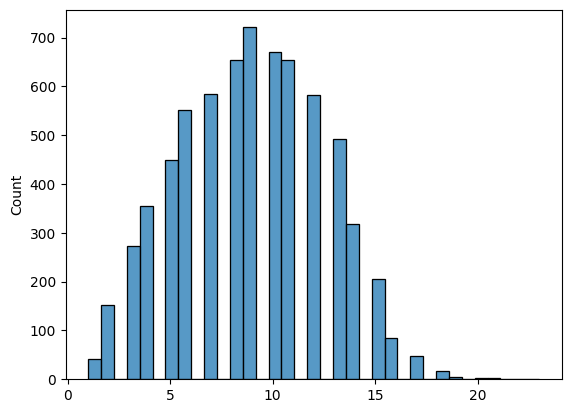

In [ ]:
sns.histplot([len(text.split(' ')) for text in text_prep])

# train-test split

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(text_prep, labels, test_size=0.2)

# Эмбединги

Воспользуемся SentenceTransformer. Немного проще, да и мы ведь с предложениями работаем

In [ ]:
model = SentenceTransformer('all-mpnet-base-v1')

In [ ]:
print("Max Sequence Length:", model.max_seq_length)

Max Sequence Length: 512


In [ ]:
print("Max Sequence Length:", model.max_seq_length)
model.max_seq_length = 32
print("Max Sequence Length:", model.max_seq_length)

Max Sequence Length: 512
Max Sequence Length: 32


In [ ]:
X_train.index = range(len(X_train))
X_val.index = range(len(X_val))
Y_train.index = range(len(Y_train))
Y_val.index = range(len(Y_val))

In [ ]:
train_embeddings = model.encode(X_train)
val_embeddings = model.encode(X_val)

# Другие эмбеддинги

Здесь также используем трансформер из SentenceTransformer, но он заточен на задачу классификации:

In [ ]:
another_model = SentenceTransformer('tomaarsen/setfit-absa-bge-small-en-v1.5-restaurants-aspect')

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

config_setfit.json:   0%|          | 0.00/140 [00:00<?, ?B/s]

model_head.pkl:   0%|          | 0.00/3.92k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
print("Max Sequence Length:", another_model.max_seq_length)

Max Sequence Length: 512


In [ ]:
print("Max Sequence Length:", another_model.max_seq_length)
another_model.max_seq_length = 32
print("Max Sequence Length:", another_model.max_seq_length)

Max Sequence Length: 512
Max Sequence Length: 32


In [ ]:
another_train_embeddings = another_model.encode(X_train)
another_val_embeddings = another_model.encode(X_val)

# Понижение размерности для одних эмбеддингов

In [ ]:
tsne = TSNE(random_state=1, perplexity=150, n_iter=500, metric="cosine")
tsne_data = tsne.fit_transform(train_embeddings)
tsne_data_test = tsne.fit_transform(val_embeddings)

<Axes: >

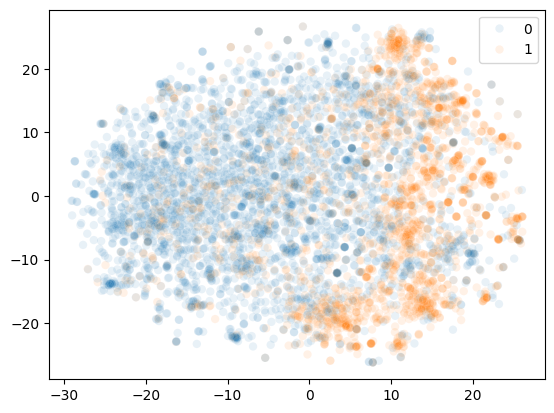

In [ ]:
sns.scatterplot(x=tsne_data[:, 0],
                    y=tsne_data[:, 1],
                    alpha=.1,
                    hue=Y_train.values)

Видно, конечно, что в целом классы тяготеют к разным сторонам, но все же очень смешанная картина

# Понижение размерности для других эмбеддингов

In [ ]:
another_tsne = TSNE(random_state=1, perplexity=300, n_iter=500, metric="cosine")
another_tsne_data = another_tsne.fit_transform(another_train_embeddings)
another_tsne_data_test = tsne.fit_transform(another_val_embeddings)

<Axes: >

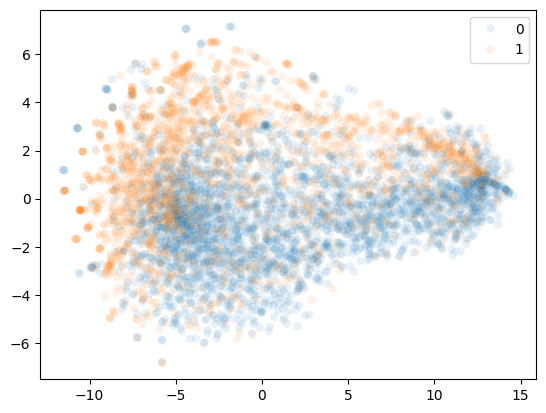

In [ ]:
sns.scatterplot(x=another_tsne_data[:, 0],
                    y=another_tsne_data[:, 1],
                    alpha=.1,
                    hue=Y_train.values)

В целом похожая история, очень сильно перемешанны данные где-то посередине

# Классификация

## Baseline бустинг

In [ ]:
clf_boost = xgboost.XGBClassifier()
clf_boost.fit(tsne_data, Y_train)
predictions = clf_boost.predict(tsne_data_test)
print("Val set f1_score:", np.round(f1_score(Y_val, predictions), 3))
print("Val set Accuracy_score:", np.round(accuracy_score(Y_val, predictions), 3))

Val set f1_score: 0.017
Val set Accuracy_score: 0.577


In [ ]:
print(classification_report(Y_val, predictions))

              precision    recall  f1-score   support

           0       0.59      0.96      0.73       818
           1       0.14      0.01      0.02       554

    accuracy                           0.58      1372
   macro avg       0.36      0.48      0.37      1372
weighted avg       0.41      0.58      0.44      1372



У первого трансформера совсем не получилось предсказать 1 класс.

In [ ]:
another_clf_boost = xgboost.XGBClassifier()
another_clf_boost.fit(another_tsne_data, Y_train)
another_predictions = another_clf_boost.predict(another_tsne_data_test)
print("Val set f1_score:", np.round(f1_score(Y_val, another_predictions), 3))
print("Val set Accuracy_score:", np.round(accuracy_score(Y_val, another_predictions), 3))

Val set f1_score: 0.478
Val set Accuracy_score: 0.685


In [ ]:
print(classification_report(Y_val, another_predictions))

              precision    recall  f1-score   support

           0       0.68      0.91      0.77       818
           1       0.72      0.36      0.48       554

    accuracy                           0.69      1372
   macro avg       0.70      0.63      0.63      1372
weighted avg       0.69      0.69      0.65      1372



Здесь ситуация чуть более равная, но все равно обе модели справились очень плохо. Это в целом ожидаемо.

## Подбор гиперпараметров

Легонький:

In [ ]:
param_grid = {'n_estimators': [200, 300, 400],
              'max_depth': [4, 6],
              'max_leaves': [0],
              'grow_policy': ['depthwise'],
              'booster': ['gbtree']}

another_param_grid = {'n_estimators': [200, 300, 400],
              'max_depth': [4, 6],
              'max_leaves': [0],
              'grow_policy': ['depthwise'],
              'booster': ['gbtree']}

In [ ]:
opt = GridSearchCV(xgboost.XGBClassifier(),
                   param_grid, scoring='f1', cv=3,
                   verbose=4, error_score='raise', refit=True)

another_opt = GridSearchCV(xgboost.XGBClassifier(),
                   another_param_grid, scoring='f1', cv=3,
                   verbose=4, error_score='raise', refit=True)

In [ ]:
opt.fit(tsne_data, Y_train)
another_opt.fit(another_tsne_data, Y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END booster=gbtree, grow_policy=depthwise, max_depth=4, max_leaves=0, n_estimators=200;, score=0.706 total time=   0.3s
[CV 2/3] END booster=gbtree, grow_policy=depthwise, max_depth=4, max_leaves=0, n_estimators=200;, score=0.732 total time=   0.3s
[CV 3/3] END booster=gbtree, grow_policy=depthwise, max_depth=4, max_leaves=0, n_estimators=200;, score=0.716 total time=   0.3s
[CV 1/3] END booster=gbtree, grow_policy=depthwise, max_depth=4, max_leaves=0, n_estimators=300;, score=0.703 total time=   0.5s
[CV 2/3] END booster=gbtree, grow_policy=depthwise, max_depth=4, max_leaves=0, n_estimators=300;, score=0.722 total time=   0.7s
[CV 3/3] END booster=gbtree, grow_policy=depthwise, max_depth=4, max_leaves=0, n_estimators=300;, score=0.714 total time=   0.8s
[CV 1/3] END booster=gbtree, grow_policy=depthwise, max_depth=4, max_leaves=0, n_estimators=400;, score=0.703 total time=   0.8s
[CV 2/3] END booster=gbtree, grow_pol

GridSearchCV(cv=3, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'booster': ['gbtree'], 'grow_policy': ['depthwise'],
                         'max_depth': [4, 6], 'max_leaves': [0],
                         'n_estimators': [200, 300, 400]},
             scoring='f1', verbose=4)

In [ ]:
opt.best_params_

{'booster': 'gbtree',
 'grow_policy': 'depthwise',
 'max_depth': 4,
 'max_leaves': 0,
 'n_estimators': 200}

In [ ]:
another_opt.best_params_

{'booster': 'gbtree',
 'grow_policy': 'depthwise',
 'max_depth': 4,
 'max_leaves': 0,
 'n_estimators': 200}

Ну и получим посмотрим тестовые результаты на "лучших" моделях:

In [ ]:
predictions = opt.predict(tsne_data_test)
print ("Val set f1_score:", np.round(f1_score(Y_val, predictions), 3))
print ("Val set Accuracy_score:", np.round(accuracy_score(Y_val, predictions), 3))

Val set f1_score: 0.013
Val set Accuracy_score: 0.574


In [ ]:
print(classification_report(Y_val, predictions))

              precision    recall  f1-score   support

           0       0.59      0.96      0.73       818
           1       0.10      0.01      0.01       554

    accuracy                           0.57      1372
   macro avg       0.34      0.48      0.37      1372
weighted avg       0.39      0.57      0.44      1372



In [ ]:
another_predictions = another_opt.predict(another_tsne_data_test)
print ("Val set f1_score:", np.round(f1_score(Y_val, another_predictions), 3))
print ("Val set Accuracy_score:", np.round(accuracy_score(Y_val, another_predictions), 3))

Val set f1_score: 0.502
Val set Accuracy_score: 0.695


In [ ]:
print(classification_report(Y_val, another_predictions))

              precision    recall  f1-score   support

           0       0.68      0.91      0.78       818
           1       0.74      0.38      0.50       554

    accuracy                           0.69      1372
   macro avg       0.71      0.64      0.64      1372
weighted avg       0.70      0.69      0.67      1372



Здесь ситуация не сильно изменилась. Оценки +- остались те же, вторая модель не так сильно проваливается с предсказанием 1 признака, как первая. Вероятно, как раз из-за своей специализации.

## Логистическая регрессия

Посмотрим что сможет логистическая регрессия:

In [ ]:
log_reg = LogisticRegression(random_state=1, class_weight='balanced')
log_reg.fit(tsne_data, Y_train)
predictions = log_reg.predict(tsne_data_test)
print("Val set f1_score:", np.round(f1_score(Y_val, predictions), 3))
print("Val set Accuracy_score:", np.round(accuracy_score(Y_val, predictions), 3))

Val set f1_score: 0.317
Val set Accuracy_score: 0.466


In [ ]:
print(classification_report(Y_val, predictions))

              precision    recall  f1-score   support

           0       0.55      0.57      0.56       818
           1       0.33      0.31      0.32       554

    accuracy                           0.47      1372
   macro avg       0.44      0.44      0.44      1372
weighted avg       0.46      0.47      0.46      1372



In [ ]:
another_log_reg = LogisticRegression(random_state=1, class_weight='balanced')
another_log_reg.fit(another_tsne_data, Y_train)
another_predictions = another_log_reg.predict(another_tsne_data_test)
print("Val set f1_score:", np.round(f1_score(Y_val, another_predictions), 3))
print("Val set Accuracy_score:", np.round(accuracy_score(Y_val, another_predictions), 3))

Val set f1_score: 0.634
Val set Accuracy_score: 0.685


In [ ]:
print(classification_report(Y_val, another_predictions))

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       818
           1       0.60      0.68      0.63       554

    accuracy                           0.69      1372
   macro avg       0.68      0.68      0.68      1372
weighted avg       0.69      0.69      0.69      1372



Вывод по логистической регрессии:

Даже по эмбеддингам из первой модели логистической регрессии здесь удалось выдать отноистельно сбалансированное предсказание. Что касается вторых эмбеддингов, то здесь результат даже лучше, чем из бустинга.

Но в целом в данном случае использовать понижение размерности как непосредственно данные - не получилось